<a href="https://colab.research.google.com/github/LuisaJ95/analitica3/blob/main/Salud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#conectar con google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
skin_df = pd.read_csv('/content/drive/MyDrive/Analitica III/SALUD/salud/HAM10000_metadata.csv')

In [ ]:
SIZE=64

# label encoding para los tipos de lunares
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

<ipython-input-5-b23c8a956170>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


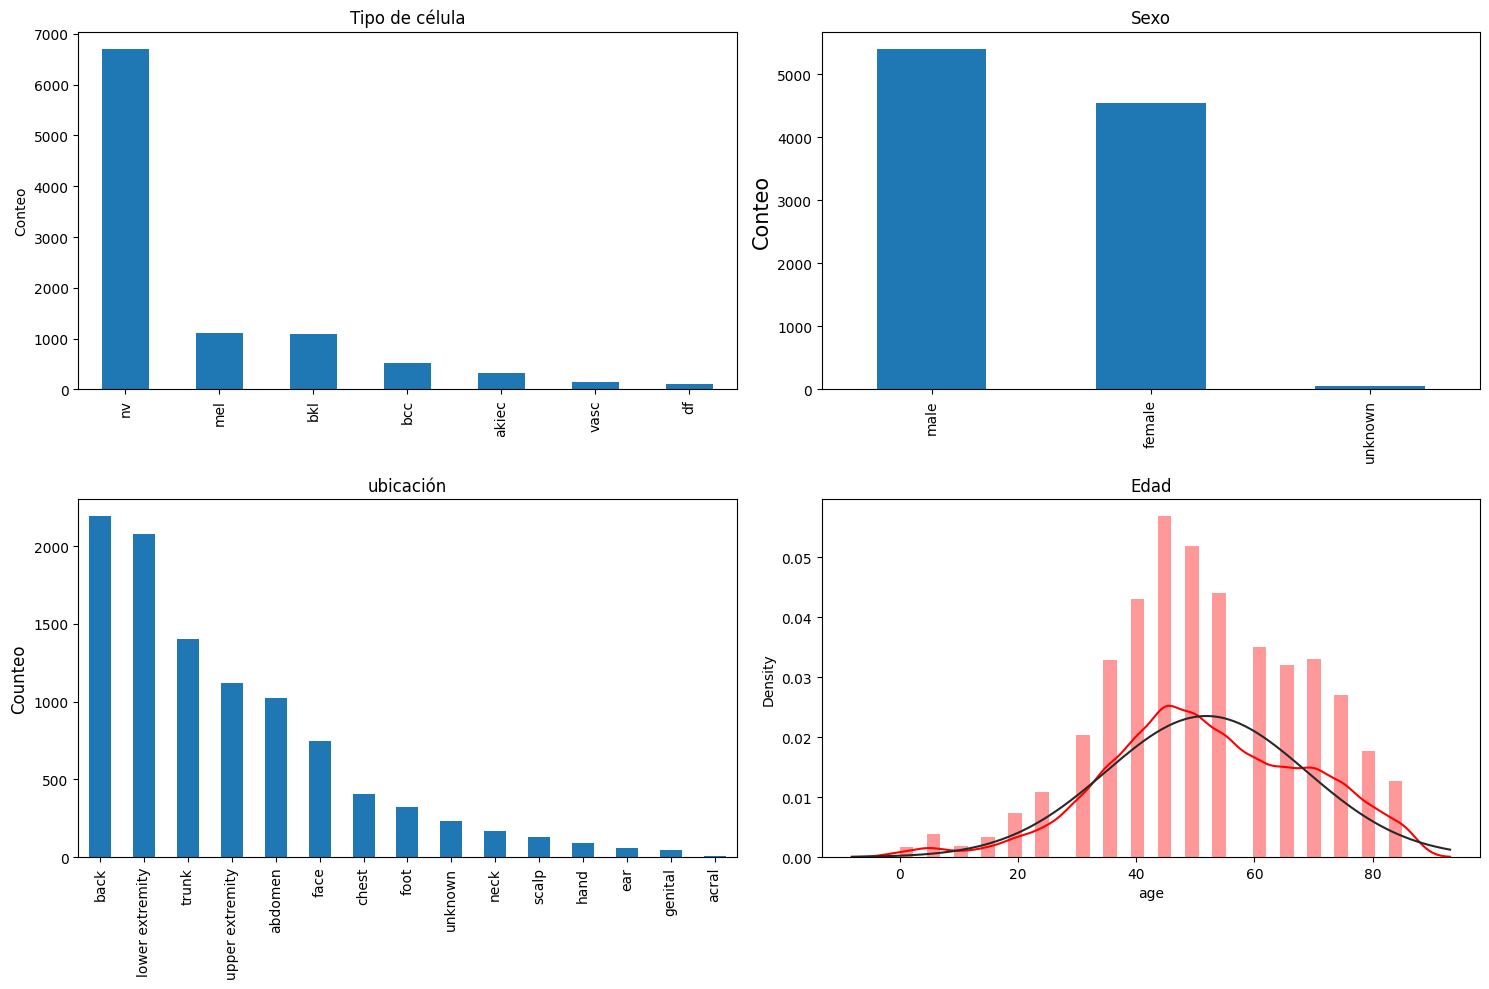

In [ ]:
# Data distribution 
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Conteo')
ax1.set_title('Tipo de célula');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Conteo', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Counteo',size=12)
ax3.set_title('ubicación')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [ ]:
# Crear la nueva columna que indica si la lesión es maligna o benigna
skin_df['label2'] = skin_df['dx'].apply(lambda x: 1 if x in ['akiec', 'bcc', 'mel'] else 0)
skin_df=skin_df.drop(['label'], axis=1)
# Mostrar el dataframe resultante
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,label2
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,1
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,1
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,1
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,1


In [ ]:
# Distribucion de los datos segun su clase
from sklearn.utils import resample
print(skin_df['label2'].value_counts())

0    8061
1    1954
Name: label2, dtype: int64


In [ ]:
#Balanceo de datos.

df_0 = skin_df[skin_df['label2'] == 0]
df_1 = skin_df[skin_df['label2'] == 1]

n_samples0=3000
n_samples1=1954
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples0, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples1, random_state=42) 


skin_df_balanced = pd.concat([df_0_balanced,df_1_balanced])

In [ ]:
print(skin_df_balanced['label2'].value_counts())

0    3000
1    1954
Name: label2, dtype: int64


In [ ]:
skin_df_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label2
8896,HAM_0004288,ISIC_0026445,nv,histo,35.0,male,chest,0
9229,HAM_0001541,ISIC_0028766,nv,consensus,30.0,male,trunk,0
860,HAM_0001053,ISIC_0030998,bkl,consensus,55.0,female,chest,0
7014,HAM_0007548,ISIC_0026633,nv,histo,45.0,male,foot,0
6850,HAM_0005447,ISIC_0027427,nv,histo,70.0,male,back,0
...,...,...,...,...,...,...,...,...
9866,HAM_0004780,ISIC_0030245,akiec,histo,75.0,male,lower extremity,1
1545,HAM_0003625,ISIC_0032875,mel,histo,75.0,male,abdomen,1
1839,HAM_0001344,ISIC_0033055,mel,histo,45.0,male,back,1
2895,HAM_0005379,ISIC_0032092,bcc,histo,45.0,male,upper extremity,1


In [ ]:
#guardar la tabla en formato csv
ruta = '/content/drive/MyDrive/Analitica III/SALUD/tablaimgg.csv'
skin_df_balanced.to_csv(ruta , index=False)